# Homework 1 AS4501-1

Course Instructor: Francisco Förster

Author: Álvaro Cáceres

In [2]:
## Importing libraries


# Recommended libraries

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import corner
import astropy.units as u 
import astropy.cosmology
import dill

# Linear regression libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor

# MCMC libraries

import emcee

# SDSS visualization

from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.coordinates import SkyCoord
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from photutils.centroids import centroid_com
from astropy.wcs import WCS


# Configs

pd.set_option('display.max_rows', 10)


## Problem 1

The **Fundamental Plane** is a key empirical relation for elliptical galaxies, linking two distance-independent observables (central velocity dispersion and mean surface brightness) with a distance-dependent observable (effective radius). This relation has historically been used to estimate galaxy distances. More importantly, its existence provides insights into the underlying physics of galaxy formation and evolution. Studying this plane allows us to understand the scaling relations of elliptical galaxies and explore potential outliers or deviations from expected behavior.

To quantify the Fundamental Plane, we use the dataset `fundamental_plane.csv` compiled by Djorgovski & Davis (1987), which provides measurements of the effective radius ($log(re_{pc})$), central velocity dispersion ($log(\sigma)$), and mean surface brightness ($\mu$) for elliptical galaxies. By performing linear regressions—including OLS, Lasso, Ridge, and Huber regression—on these parameters, we aim to find the best-fit plane describing the relation between these observables. Visualizing the data and the resulting fits allows us to assess the quality of the model, detect potential outliers, and evaluate how well the plane captures the intrinsic scaling relations among galaxies.

In [15]:
# We load and visualize the dataset
data = pd.read_csv("fundamental_plane.csv")
data

,ID,log_re_arcsec,err_log_re_arcsec,log_re_pc,err_log_re_pc,m,err_m,M,err_M,mu,err_mu,ellip,err_elip,log_sigma,err_log_sigma
0,NGC-57,1.29,0.02,3.70,0.02,11.86,0.44,-21.76,0.44,19.28,0.47,0.17,0.02,2.502,0.025
1,NGC-97,1.18,0.01,3.54,0.01,12.44,0.16,-20.92,0.16,19.55,0.17,0.06,0.02,2.086,0.117
2,NGC-194,1.40,0.01,3.79,0.01,11.94,0.06,-21.55,0.06,20.14,0.08,0.11,0.02,2.332,0.051
3,NGC-221,1.65,0.01,2.16,0.05,7.89,0.21,-16.21,0.31,17.27,0.22,0.17,0.02,1.898,0.055
4,NGC-410,1.62,0.01,4.03,0.01,11.26,0.30,-22.36,0.30,20.37,0.32,0.26,0.02,2.458,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NGC-7785,1.55,0.02,3.80,0.02,11.23,0.17,-21.57,0.17,19.65,0.21,0.44,0.01,2.382,0.045
102,IC-179,1.15,0.01,3.47,0.02,12.45,0.14,-20.73,0.14,19.28,0.17,0.16,0.02,2.447,0.030
103,IC-962,0.80,0.04,3.31,0.04,13.24,0.22,-20.86,0.22,18.31,0.28,0.10,0.01,2.185,0.086
104,IC-1211,1.10,0.02,3.56,0.02,12.75,0.13,-21.11,0.13,19.33,0.17,0.13,0.01,2.212,0.123


As we can see `fundamental_plane.csv` contains data from more than 100 galaxies! In this experience we will be designing a linear regression that will model $log(r_e)$ as a function of $log(\theta)$ and $\mu$.

First, we will be splitting our samples into training and testing samples using a ratio of 7:3. This will assure that our testing results will be true to the behavior of our model.

In [16]:
# We define the X (independent) and Y (dependent) variables for further use in the linear regression

fplane_X = data[['log_sigma', 'mu']]
fplane_Y = data[['log_re_pc']]

# We split the data into training/testing sets

fplane_X_train, fplane_X_test, fplane_Y_train, fplane_Y_test = train_test_split(fplane_X, fplane_Y, test_size=0.3, random_state=27)

Now, as a learning experience we will model a simple regression (1st degree polynomial) and print our coefficients, Mean squared error (MSE) and variance score ($R²$). We do this to have some understanding of the model going forward. 

In [17]:
# We create our first (simple) regression

regr = LinearRegression()
regr.fit (fplane_X_train, fplane_Y_train)

# We create prediction using the testing set

fplane_Y_pred = regr.predict(fplane_X_test)

# We print our coefficients, MSE and variance

print('Coefficients: \n', regr.coef_, regr.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(fplane_Y_test, fplane_Y_pred))
print('Variance score (R2): %.2f' % r2_score(fplane_Y_test, fplane_Y_pred))

Coefficients: 
 [[1.14242356 0.31094493]] [-5.15997076]
Mean squared error (MSE): 0.03
Variance score (R2): 0.74


With what we learned in our previous experience we will now be coding a more generalized linear regression. This regression will be modeling to up to 5 degrees of polynomial and giving information about the coefficients of the fundamental plane, MSE for training and testing samples and variance score of each degree.

In [18]:
degrees = [1, 2, 3, 4, 5]

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    fplane_X_train_poly = poly.fit_transform(fplane_X_train)
    fplane_X_test_poly = poly.transform(fplane_X_test)

    regr = LinearRegression()
    regr.fit(fplane_X_train_poly, fplane_Y_train)
    fplane_Y_pred = regr.predict(fplane_X_test_poly)

    coefs = regr.coef_.ravel()[1:] # Get rid of bias coef
    coefss = coefs_str = [f"{c:.5f}" for c in coefs]

    intercept = regr.intercept_
    interceptt = intercept.item()

    # We make different predictions for cross-validation

    fplane_Y_test_pred = regr.predict(fplane_X_test_poly)    
    fplane_Y_train_pred = regr.predict(fplane_X_train_poly)    


    mse_test = mean_squared_error(fplane_Y_test, fplane_Y_test_pred)
    mse_train = mean_squared_error(fplane_Y_train, fplane_Y_train_pred)


    r2 = r2_score(fplane_Y_test, fplane_Y_pred)

    print(f"Degree {d}:")
    print(f"  Coefficients: {', '.join(coefss)}")
    print(f"  Intercept: {interceptt:.3f}")
    print(f"  MSE (train): {mse_train:.4f}")
    print(f"  MSE (test): {mse_test:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-"*40)


Degree 1:
  Coefficients: 1.14242, 0.31094
  Intercept: -5.160
  MSE (train): 0.0202
  MSE (test): 0.0258
  R²: 0.7404
----------------------------------------
Degree 2:
  Coefficients: 4.52046, 1.27200, -0.42480, -0.07542, -0.01971
  Intercept: -18.506
  MSE (train): 0.0164
  MSE (test): 0.0283
  R²: 0.7149
----------------------------------------
Degree 3:
  Coefficients: -27.96781, 11.93387, 18.48321, -1.04373, -0.49891, -2.52830, -0.10513, 0.03693, 0.00653
  Intercept: -65.198
  MSE (train): 0.0146
  MSE (test): 0.0303
  R²: 0.6944
----------------------------------------
Degree 4:
  Coefficients: -1267.48571, 156.39267, 790.13933, 15.15376, -12.10081, -140.79359, -32.68375, 2.94370, 0.27664, 11.22929, 2.07817, 0.47574, -0.08587, -0.00081
  Intercept: -113.379
  MSE (train): 0.0132
  MSE (test): 0.0301
  R²: 0.6969
----------------------------------------
Degree 5:
  Coefficients: -82413.62308, -1571.58594, 48473.83888, 5836.71356, -156.42749, -9353.68032, -4256.92142, 39.31518, 5.

We can see that as the polynomial degrees gets higher so do the coefficients, which go up in magnitude exponentially as the degree increases, this is expected in high degree polynomials as the variables grow exponentially in size the coefficients need to grow too in compensation. Same can be said for the intercept. As for the variance score, we can see that it has a tendency to decrease as the degree increases which indicates that some over compensation is coming into play for the higher degrees.

To take a look at the behavior of the MSE values we graph them:

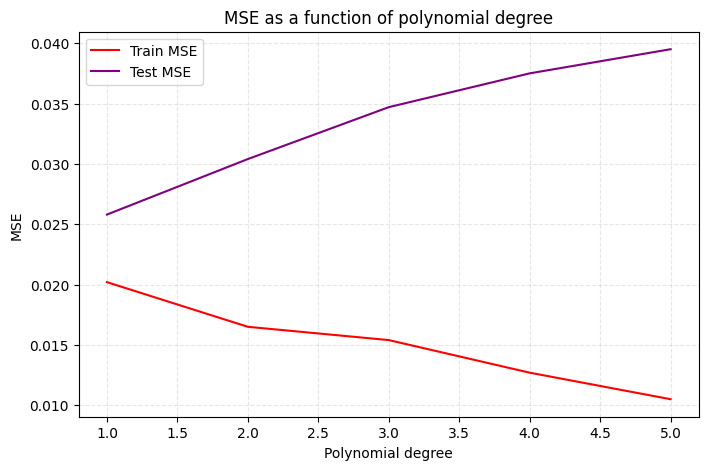

In [19]:
# We graph our MSE values

mse_train = [0.0202, 0.0165, 0.0154, 0.0127, 0.0105] 
mse_test =  [0.0258, 0.0304, 0.0347, 0.0375, 0.0395]

plt.figure(figsize=(8,5))
plt.plot(degrees, mse_train, color = 'red', linestyle = '-', label = 'Train MSE')
plt.plot(degrees, mse_test, color = 'purple', linestyle = '-', label = 'Test MSE')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title("MSE as a function of polynomial degree")
plt.legend()
plt.grid(True, linestyle = "--", alpha = 0.3)
plt.show()

As the graph shows, the MSE for the training sample always decreases as the degree of the polynomial increases. However, the testing sample acts the opposite way, increasing the MSE as the degree grows. Going off of this information and the fact that in a Gaussian linear regression maximizing the MLE (Maximum Likelihood Estimation) value is equal to minimizing the MSE value we can conclude that **the first degree linear function provides the best fit to model this linear regression**. This becomes clear by the fact that the first degree model is the one that maximizes the MLE in unseen data, while avoiding over-fitting.

Now that via cross-validation we know the best degree to proceed we can apply different models of regression. First we will start with Lasso regression:

The Lasso regression is a linear regression method that is characterized by adding a $L_1$-penalty to the loss function. This penalty creates sparsity between the coefficients, improving generalization and preventing over-fitting. Also, unlike ordinary least squares, Lasso can shrink some coefficients exactly to zero.

In [20]:
# We use the same data splits from last regression.

lasso = Lasso(alpha = 0.01) # Regularization strength
lasso.fit(fplane_X_train, fplane_Y_train)

# We make new predictions for cross-validation

fplane_Y_train_pred = lasso.predict(fplane_X_train)
fplane_Y_test_pred = lasso.predict(fplane_X_test)

# We calculate Coefficients

coefs = lasso.coef_
intercept = lasso.intercept_


# We calculate MSE for both samples

train_MSE = mean_squared_error(fplane_Y_train, fplane_Y_train_pred)
test_MSE = mean_squared_error(fplane_Y_test, fplane_Y_test_pred)

# We calculate R² value

r2 = r2_score(fplane_Y_test, fplane_Y_test_pred)

# We print results

print(f"Coefficients: {', '.join(f"{c:.4f}" for c in coefs)}")
print(f"Intercept: {', '.join(f"{i:.4f}" for i in intercept)}")
print(f"Train MSE: {train_MSE:.4f}")
print(f"Test MSE: {test_MSE:.4f}")
print(f"R²: {r2:.4f}")

Coefficients: 0.7270, 0.3092
Intercept: -4.1603
Train MSE: 0.0244
Test MSE: 0.0315
R²: 0.6826


Now that we have the coefficients, for a further understanding of the regression we will be comparing how the MSE behaves as the $\alpha$ (regularization strength) value increases.

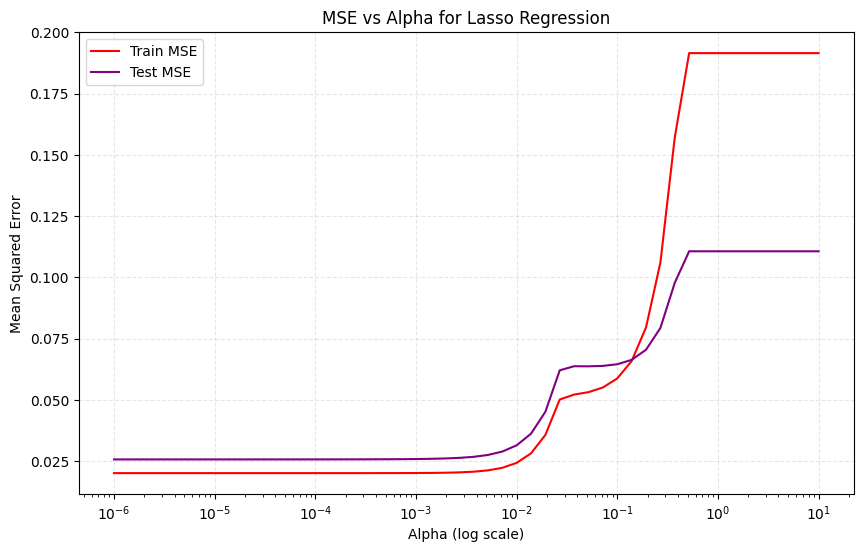

In [21]:
# We get MSE values for an interval of alphas

alphas = np.logspace(-6, 1, 50)

mse_train_list = []
mse_test_list = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(fplane_X_train,fplane_Y_train)

    fplane_Y_train_pred = lasso.predict(fplane_X_train)
    fplane_Y_test_pred = lasso.predict(fplane_X_test)

    mse_train_list.append(mean_squared_error(fplane_Y_train, fplane_Y_train_pred))
    mse_test_list.append(mean_squared_error(fplane_Y_test, fplane_Y_test_pred))

# We graph our alphas to get better visualization

plt.figure(figsize = (10,6))
plt.plot(alphas, mse_train_list, color = 'red', label = 'Train MSE', linestyle = '-')
plt.plot(alphas, mse_test_list, color = 'purple', label = 'Test MSE', linestyle = '-')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Lasso Regression')
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.show()



As we can see, the optimal $\alpha$ values for minimizing MSE are in the interval $\alpha < 0.01$.

Secondly, we will be making a Ridge regression. As with the Lasso regression, we will be using the 1st-degree function but unlike Lasso the Ridge regression is characterized for penalizing the sums of the squared coefficients and also unlike the Lasso regression this regression will not be putting coefficients to 0 (though it will make them smaller). This regression is useful for when you want to regularize your model without deleting variables.

In [22]:
# We use the same data splits from last regression.

ridge = Ridge(alpha = 0.01) # Regularization strength
ridge.fit(fplane_X_train, fplane_Y_train)

# We make new predictions for cross-validation

fplane_Y_train_pred = ridge.predict(fplane_X_train)
fplane_Y_test_pred = ridge.predict(fplane_X_test)

# We calculate Coefficients

coefs = ridge.coef_
intercept = ridge.intercept_

# We calculate MSE for both samples

train_MSE = mean_squared_error(fplane_Y_train, fplane_Y_train_pred)
test_MSE = mean_squared_error(fplane_Y_test, fplane_Y_test_pred)

# We calculate R² value

r2 = r2_score(fplane_Y_test, fplane_Y_test_pred)

# We print results

print(f"Coefficients: {', '.join(f"{c:.4f}" for c in coefs)}")
print(f"Intercept: {', '.join(f"{i:.4f}" for i in intercept)}")
print(f"Train MSE: {train_MSE:.4f}")
print(f"Test MSE: {test_MSE:.10f}")
print(f"R²: {r2:.4f}")

Coefficients: 1.1360, 0.3110
Intercept: -5.1461
Train MSE: 0.0202
Test MSE: 0.0258034567
R²: 0.7402


As with the Lasso regression we will graph how the MSE behaves in function of $\alpha$.

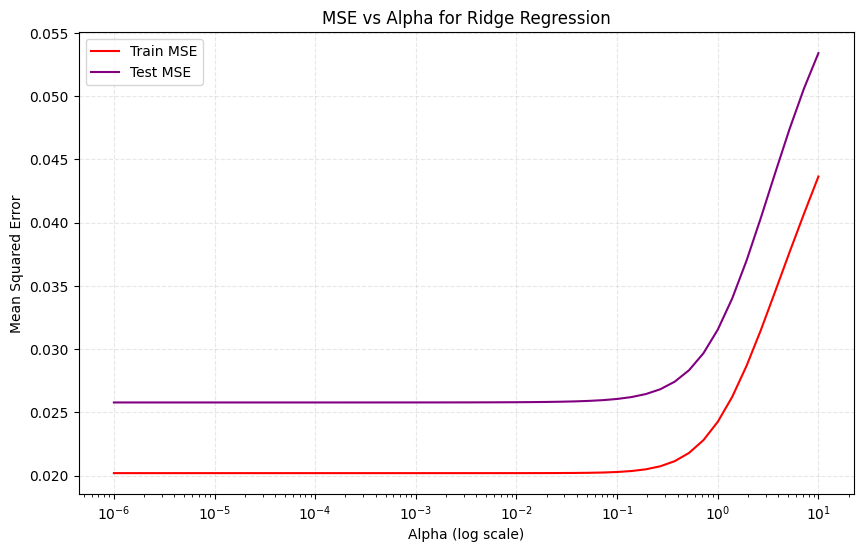

In [23]:
# We get MSE values for an interval of alphas

alphas = np.logspace(-6, 1, 50)

mse_train_list = []
mse_test_list = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(fplane_X_train,fplane_Y_train)

    fplane_Y_train_pred = ridge.predict(fplane_X_train)
    fplane_Y_test_pred = ridge.predict(fplane_X_test)

    mse_train_list.append(mean_squared_error(fplane_Y_train, fplane_Y_train_pred))
    mse_test_list.append(mean_squared_error(fplane_Y_test, fplane_Y_test_pred))

# We graph our alphas to get better visualization

plt.figure(figsize = (10,6))
plt.plot(alphas, mse_train_list, color ='red', label = 'Train MSE', linestyle = '-')
plt.plot(alphas, mse_test_list, color ='purple', label = 'Test MSE', linestyle = '-')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Ridge Regression')
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.show()

In this case we can see some more expected behavior for our function, where the MSE vs $\alpha$ function looks almost like a exponential shape with the MSE minimizing $\alpha$ value being in the interval $\alpha < 0.1$ and reaching lower MSE values than those reached with the Lasso regression.

When analyzing how the coefficients behave in each of the linear regressions there's a few main differences that are worth noting:

* In the original **LinearRegression (OLS)** the coefficients adjusted only to minimize the MSE when training, this without any reduction via regularization. This usually results in bigger coefficients

* In the **Lasso regression** we can see that some coefficients can become exactly 0, this usually happens with bigger alpha values which is very useful if you suspect that not all variables are important. Other than that if you put smaller alpha values you will see very similar coefficient values to that of the OLS regression.

* Last but not least, the **Ridge regression** penalizes the sum of the squared coefficients which means that these values will decrease but rarely reach zero, which is useful when you have all the important variables but want to avoid an over-fit. Also if you put bigger values for alpha all the coefficients decrease, making them more moderate.

We want to see if our data set contains any outliers. To do this we will visualize our data set with a simple OLS regression for reference. To better visualize the 3 dimensional relation we will plot $log(r_e)$ in the Y-axis and $A \times log(\sigma) + B \times \mu$ on the X-axis.

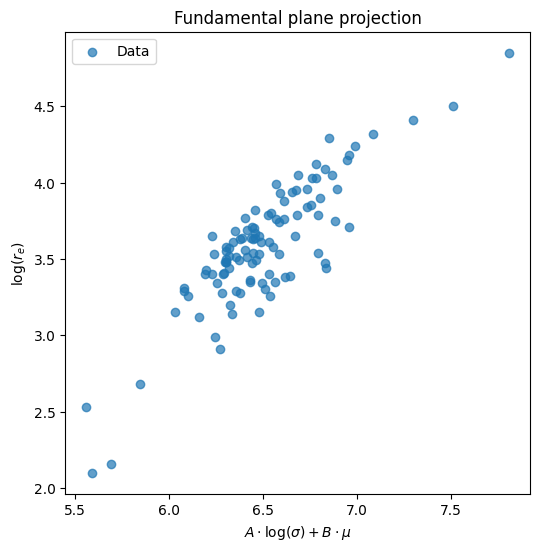

In [24]:
# We name our variables

log_sigma = data[['log_sigma']]
log_re = data[['log_re_pc']]
mu = data[['mu']]


# OLS coefficients

A = 1.14242 
B = 0.31094  

# X and Y axis
x = A * np.log10(log_sigma.values.flatten()) + B * mu.values.flatten() 
y = log_re.values.flatten()


# We graph our data and regression

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.7, label = "Data")

plt.xlabel(r"$A \cdot \log(\sigma) + B \cdot \mu$")
plt.ylabel(r"$\log(r_e)$")
plt.legend()
plt.title("Fundamental plane projection")
plt.show()

As we can see the data represented in the graph shows a $x=y$ relation between the axis, which satisfies the fundamental plane equation $log(r_e)$ = $A \times log(\sigma) + B \times \mu$. Other than that we can see some outliers in the data, such as some data points on the lower left or on the upper right of our graph. To remedy this we will perform a **Hubber loss regression**.

**Hubber loss** is a loss function used in regression that combines dynamically the advantages of MSE for small errors and MAE (Mean Absolute Error) for larger errors (useful for outliers). This assures a smoother penalization of the data points and is very useful for data which has few outliers (like ours). 

In [25]:
hubber = HuberRegressor(epsilon = 1.47) # Regularization strength
hubber.fit(fplane_X_train, fplane_Y_train.values.ravel())

# We make new predictions for cross-validation

fplane_Y_train_pred = hubber.predict(fplane_X_train)
fplane_Y_test_pred = hubber.predict(fplane_X_test)

# We calculate Coefficients

coefs = hubber.coef_
intercept = hubber.intercept_

# We calculate MSE for both samples

train_MSE = mean_squared_error(fplane_Y_train, fplane_Y_train_pred)
test_MSE = mean_squared_error(fplane_Y_test, fplane_Y_test_pred)

# We calculate R² value

r2 = r2_score(fplane_Y_test, fplane_Y_test_pred)

# We print results

print(f"Coefficients: {', '.join(f"{c:.4f}" for c in coefs)}")
print(f"Intercept: {intercept:.4f}")
print(f"Train MSE: {train_MSE:.4f}")
print(f"Test MSE: {test_MSE:.10f}")
print(f"R²: {r2:.4f}")

Coefficients: 1.1454, 0.2918
Intercept: -4.7866
Train MSE: 0.0207
Test MSE: 0.0257012919
R²: 0.7412


The Hubber loss regression is characterized by a hyper-parameter $\varepsilon$ which is in charge of deciding when to use MSE or MAE penalization, this is in function of how big is the error-value in a data point. 

In `sklearn` $\varepsilon$ is restricted by the condition $\varepsilon >1$ and we want a $\varepsilon$ value that assures the minimum test MSE and a reasonable train MSE (to not indicate over fitting). To check this we will use cross-validation and graph our MSE values vs. $\varepsilon$.

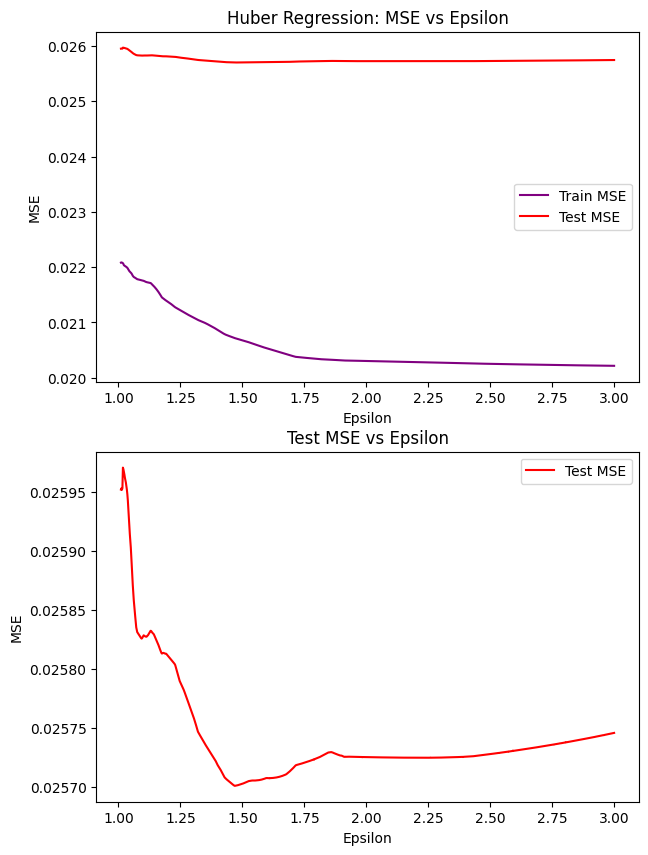

In [26]:
epsilons = np.linspace(1.01, 3, 1000) 
test_mse_list = []
train_mse_list = []

for eps in epsilons:
    huber = HuberRegressor(epsilon=eps)
    huber.fit(fplane_X_train, fplane_Y_train.values.ravel()) 
    y_train_pred = huber.predict(fplane_X_train)
    y_test_pred = huber.predict(fplane_X_test)

    train_mse = mean_squared_error(fplane_Y_train, y_train_pred)
    test_mse = mean_squared_error(fplane_Y_test, y_test_pred)

    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.plot(epsilons, train_mse_list, '-', color = 'purple', label="Train MSE")
plt.plot(epsilons, test_mse_list, '-', color = 'red', label="Test MSE")
plt.xlabel("Epsilon")
plt.ylabel("MSE")
plt.title("Huber Regression: MSE vs Epsilon")
plt.legend()
plt.subplot(2,1,2)
plt.plot(epsilons, test_mse_list, '-', color = 'red', label="Test MSE")
plt.xlabel("Epsilon")
plt.ylabel("MSE")
plt.title("Test MSE vs Epsilon")
plt.legend()
plt.show()


By looking at our results we can confidently say that $\varepsilon_{opt} \approx 1.47$, which achieves an MSE of approx. 2.7. By this metric we can say that **Hubber loss is the best regression for this data set**, successfully compensating for our outlier data points and achieving the best error reduction out of the sample of regression tried previously. This experience finally illustrates the power of linear regression by reliably characterizing the fundamental plane even in presence of anomalous measurements. 

## Problem 2


The $M_\bullet - \sigma$ relation links the mass of a galaxy’s central supermassive black hole with the velocity dispersion of stars in its bulge, connecting parsec- and kiloparsec-scale processes. This correlation is key to understanding the co-evolution of black holes and galaxies, though its physical origin remains uncertain.

In this project, we'll analyze the file `M_sigma.csv` (which contains data from Harris et al. (2013)) using a Bayesian statistical framework, accounting for observational uncertainties, possible outliers, and intrinsic scatter. The goal is to derive the $M_\bullet - \sigma$ relation directly from the data and explore the strengths and limitations of the inference methods applied.

In [27]:
# We load and visualize the data
data = pd.read_csv("M_sigma.csv")
data.describe()

,logSigma,err_logSigma,logM,err_logM
count,46.000000,46.000000,46.000000,46.000000
mean,0.015672,0.046630,8.399348,0.146522
std,0.181093,0.023594,0.902422,0.095113
min,-0.474955,0.014500,6.460000,0.030000
25%,-0.088215,0.035000,7.860000,0.080000
50%,0.053839,0.040000,8.555000,0.125000
75%,0.169452,0.058750,8.975000,0.193750
max,0.301898,0.100000,10.320000,0.435000


As we can see `M_sigma.csv` contains data from more than 40 galaxies! For better visualization we will scatter plot our data points, that way we can see how these parameters really interact and the existence of possible outliers.

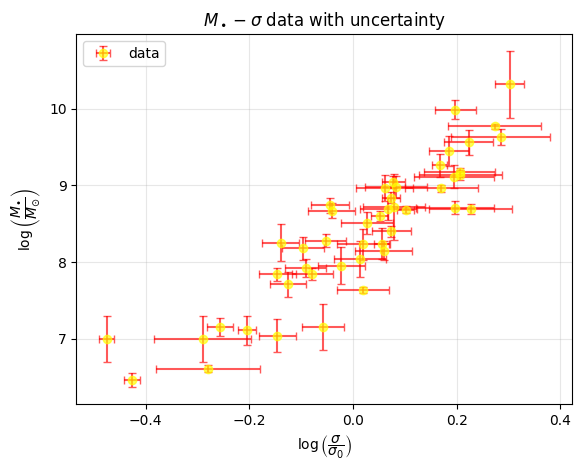

In [28]:
# Parameters

x = data['logSigma'].values
y = data['logM'].values
x_err = data['err_logSigma'].values
y_err = data['err_logM'].values
galaxy_type = data['Type'].values

# Scatter plot with errors
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', color = 'yellow', ecolor='red', label = "data", alpha=0.65, capsize=3)
plt.xlabel(r'$\log \left( \dfrac{\sigma}{\sigma_{0}} \right)$')
plt.ylabel(r'$\log \left( \dfrac{M_{\bullet}}{M_{\odot}} \right)$')
plt.title(r'$M_\bullet - \sigma$ data with uncertainty')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

As we can see the data represented in the graph shows pretty much a $x=y$ relation between the axis, which satisfies the $M_\bullet - \sigma$ relation. Other than that we can't see many major outliers in the data, as every data point follows a reasonable behavior regarding the other points.

We want to find the joint probability distribution for the parameters $(\alpha , \beta , \omega)$ for the $M_\bullet - \sigma$ relation $\log \left(\frac{M_\bullet}{M_\odot}\right)= \alpha + \beta \, \log \left(\frac{\sigma}{\sigma_0}\right)+ \mathcal{N}(0, w^2)$. To do this we will perform a **full Bayesian Analysis** using the `emcee` python library.

100%|██████████| 5000/5000 [00:05<00:00, 957.19it/s]


Results:
alpha = 8.349950080497536 +/- 0.05522400836534096
beta  = 4.426504276966659 +/- 0.2938410515537011
w     = 0.2714953990404872 +/- 0.05956468469483122


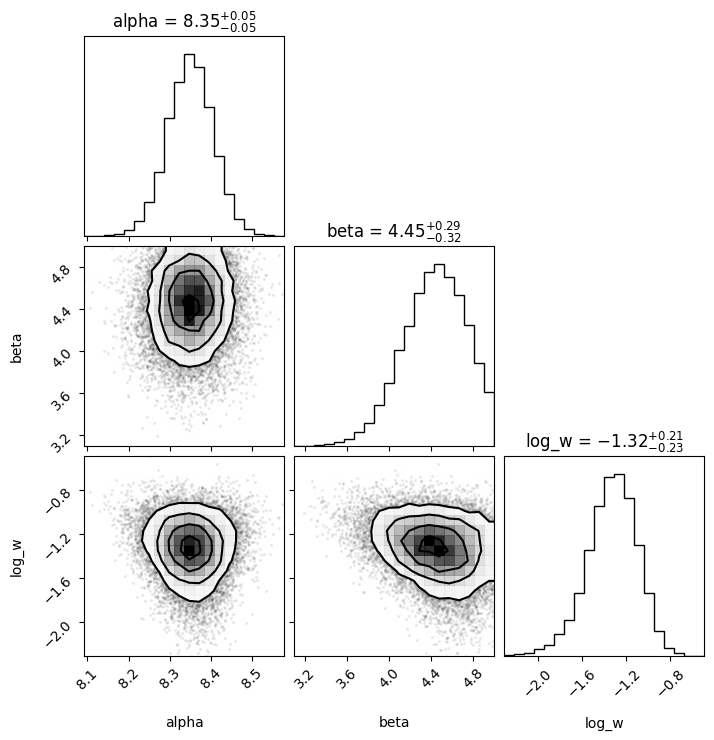

In [29]:
# We define log_prior
def log_prior(theta):
    alpha, beta, log_w = theta
    w = np.exp(log_w)
    # Priors similar to documentation results
    if 6.0 < alpha < 10.0 and 1 < beta < 5 and 0.1 < w < 5:
        return 0.0 
    return -np.inf  # Out of range

# We define log-likelihood
def log_likelihood(theta, x, y, x_err, y_err):
    alpha, beta, log_w = theta
    w = np.exp(log_w)
    y_model = alpha + beta * x
    var_tot = y_err**2 + (beta * x_err)**2 + w**2
    return -0.5 * np.sum((y - y_model)**2 / var_tot + np.log(2 * np.pi * var_tot))

# We define log-posterior
def log_posterior(theta, x, y, x_err, y_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, x_err, y_err)

# We setup emcee
ndim = 3       # alpha, beta, log_w
nwalkers = 50
nsteps = 5000

# Start near reasonable values
initial = np.array([8.5, 4.0, np.log(0.3)])
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# We run emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, x_err, y_err))
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract samples
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
alpha_samples, beta_samples, log_w_samples = samples.T
w_samples = np.exp(log_w_samples)

print("Results:")
print("alpha =", np.mean(alpha_samples), "+/-", np.std(alpha_samples))
print("beta  =", np.mean(beta_samples), "+/-", np.std(beta_samples))
print("w     =", np.mean(w_samples), "+/-", np.std(w_samples))

# Finally we do a corner plot
fig = corner.corner(samples, labels=['alpha','beta','log_w'],
                    show_titles=True, title_fmt=".2f")
plt.show()

Our results for $(\alpha, \beta, \omega)$ are pretty consistent with the literature (Ferrarese & Merritt 2000, Gültekin 2009 indicate $\alpha \sim 8-9.5$ and $\beta \sim 4-5$) which indicate a successful fit. Other than that, our corner plot shows the posterior distributions for the model parameters 
$𝛼
, 
𝛽
,
\omega
$. The marginalized histograms are approximately Gaussian, indicating that the chains converged well and that the parameters are well constrained. Finally, the weak correlation between parameters, visible in the off-diagonal panels, is typical of linear regression problems with intrinsic scatter.

To see how our fit correlates with our data we will do a fan uncertainty plot. This will show the Bayesian credibility of our model.

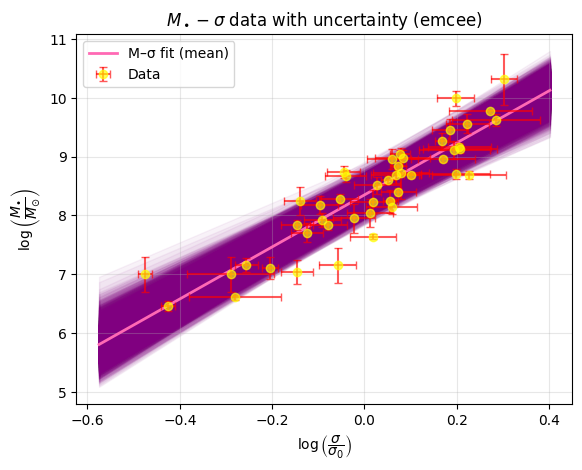

In [30]:
# Draw M-sigma with uncertainty
x_plot = np.linspace(min(x)-0.1, max(x)+0.1, 100)

# Uncertainty fan
idx = np.random.choice(len(samples), 500, replace=False)
for a, b, w in zip(alpha_samples[idx], beta_samples[idx], w_samples[idx]):
    y_model = a + b * x_plot
    plt.fill_between(x_plot, y_model - w, y_model + w, color='purple', alpha=0.05)

# Mean line
y_mean = np.mean(alpha_samples) + np.mean(beta_samples) * x_plot
plt.plot(x_plot, y_mean, color='hotpink', lw=2, label='M–σ fit (mean)')

# Data
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', color='yellow', ecolor='red', alpha=0.65, capsize = 3, label='Data')
plt.title(r'$M_\bullet - \sigma$ data with uncertainty (emcee)')
plt.xlabel(r'$\log \left( \dfrac{\sigma}{\sigma_{0}} \right)$')
plt.ylabel(r'$\log \left( \dfrac{M_{\bullet}}{M_{\odot}} \right)$')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

This plot displays the $M_\bullet - \sigma$ relation for our sample. The yellow points with error bars represent the observational data, while the purple band shows the posterior predictive distribution from our Bayesian fit. The pink line corresponds to the mean relation and the shaded confidence region captures the intrinsic scatter, which we estimate as $\omega \sim 0.3$ dex. Importantly, the fit recovers both the tight correlation and the level of intrinsic dispersion observed in the $M_\bullet - \sigma$ relation.

Overall, the Bayesian inference reproduces the well-known $M_\bullet - \sigma$ relation. The results are consistent with the literature and the fit represents our data pretty accurately. The recovered slope and intercept are consistent with previous observational determinations, and the estimated intrinsic scatter highlights the complexity of the physical processes connecting the central black hole and its host galaxy.

## Problem 3

The goal of this exercise is to understand the limitations of photometric measurements in large surveys such as SDSS. By estimating the image depth through random aperture photometry, we can quantify the noise level and determine the limiting flux for reliable detections. This provides insight into the signal-to-noise ratio that constrains the accuracy of survey catalogs and allows us to compare our own measurements with the official SDSS results.

In this step, instead of downloading the image via `astroquery`, we directly load the pre-downloaded **SDSS DR7 r-band image** centered on the Whirlpool galaxy (RA 13:29:52.7, DEC +47:11:43). The specifications were set to a field of **20 × 20 arcminutes** with a pixel scale of **0.6 arcseconds** per pixel. These parameters define the resolution of the image: $$20 \ \text{arcmin} = 1200 \ \text{arcsec}, \quad \frac{1200}{0.6} \approx 2000 \ \text{pixels per side.}$$
The image, stored in FITS format, is then displayed for inspection and will later be used for aperture photometry and background estimation.

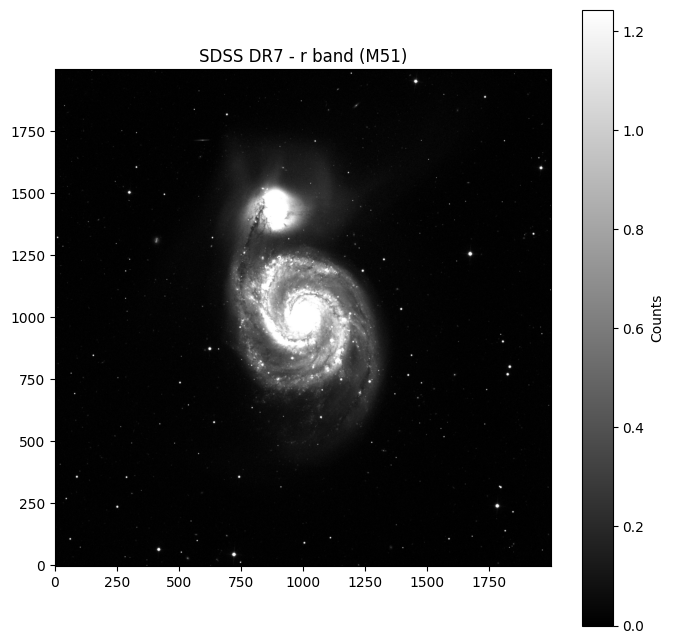

In [3]:
# Load the pre-downloaded SDSS r-band image (M51)
hdu = fits.open("Fits_data.fits")[0]
data = hdu.data

# Show image
plt.figure(figsize=(8,8))
plt.imshow(data, cmap="gray", origin="lower", vmin=0, vmax=np.percentile(data, 99))
plt.colorbar(label="Counts")
plt.title("SDSS DR7 - r band (M51)")
plt.show()

The same image can be obtained using the `astroquery.skyview` package, though not as reliably:

In [4]:
# M51 coordinates (Whirlpool Galaxy)
#coordinates = SkyCoord("13h29m52.7s +47d11m43s", frame='icrs')


## Image download (SDSS DR7, r-band)
#images = SkyView.get_images(
#    position=coordinates,
#    survey=["SDSSdr7"],
#    pixels=200)

## Save image in FITS format
#images[0].writeto('sdss_rband.fits', overwrite=True)

## Save FITS image
#hdu = fits.open('sdss_rband.fits')[0]
#data = hdu.data

## Show image
#plt.figure(figsize=(8,8))
#plt.imshow(hdu.data, cmap="gray", origin="lower", vmin=0, vmax=np.percentile(hdu.data, 99))
#plt.colorbar(label="Counts")
#plt.title("SDSS DR7 - r band (M51)")
#plt.show()

The SDSS DR7 r-band FITS image of M51 shows the bright central galaxy with visible spiral arms and star clusters. **The background appears mostly uniform** but contains several background and foreground point sources. The pixel values range from low counts in the outskirts to high counts in the core. Overall, the image clearly captures the main structures of the galaxy and surrounding field which makes it a pretty useful asset for our analysis.

To quantify the depth of the SDSS r-band image of M51, we will perform **aperture photometry** on random positions across the field. By measuring the fluxes within 3″ diameter apertures and estimating the local background, we can characterize the noise properties of the image and determine the faintest detectable sources. It is important to note that the pixel values are in raw counts and will be used to estimate the signal-to-noise ratio rather than calibrated magnitudes.

We place **1000 random circular apertures** across the M51 SDSS r-band image to sample the background. This approach allows us to estimate local flux variations while avoiding the central galaxy, providing the foundation for reliable S/N measurements.

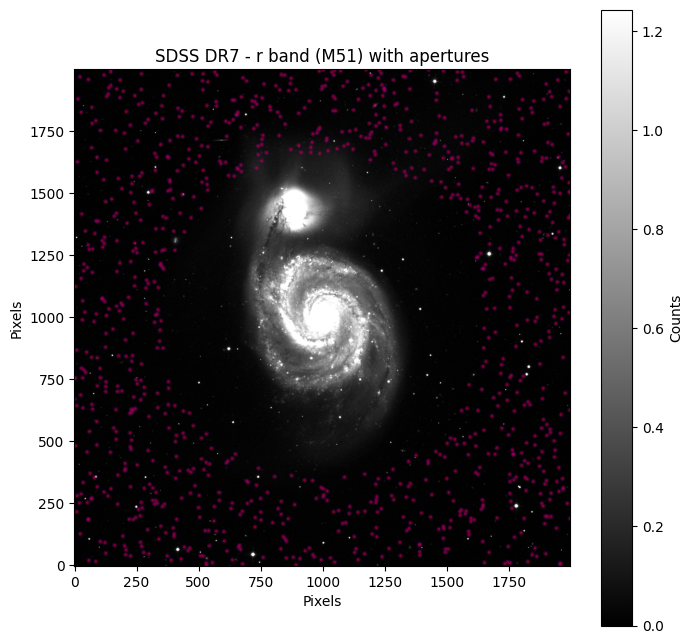

In [ ]:
# Random seed
np.random.seed(22133115)

# Define number and diameter of the apertures
n_apertures = 1000
aperture_radius = 3 / 2.0 / 0.6 
annulus_in = aperture_radius + 2   
annulus_out = aperture_radius + 5  

# Retrieve image dimensions
ny, nx = data.shape

# We generate random positions avoiding the M51 galaxy
center_x, center_y = nx//2, ny//2
avoid_radius = 650 # px, enough to cover the central galaxy

positions = []
while len(positions) < n_apertures:
    x = np.random.randint(0, nx)
    y = np.random.randint(0, ny)
    if np.hypot(x-center_x, y-center_y) > avoid_radius:
        positions.append((x,y))
positions = np.array(positions)

# Aperture and rings
apertures = CircularAperture(positions, r=aperture_radius)
annuli = CircularAnnulus(positions, r_in=annulus_in, r_out=annulus_out)

# Display the SDSS image
plt.figure(figsize=(8,8))
plt.imshow(data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(data, 99))
plt.colorbar(label='Counts')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.title('SDSS DR7 - r band (M51) with apertures')

# Plot apertures (in red) and annuli (in purple)
apertures.plot(color='red', lw=1.0, alpha=0.5)
annuli.plot(color='purple', lw=1.0, alpha=0.3)

plt.show()


The apertures are distributed evenly across the field, with annuli capturing local background. Visual inspection confirms they avoid the bright central galaxy, ensuring that subsequent flux measurements primarily sample empty sky regions.

Using the apertures, we measure fluxes and compute the signal-to-noise ratio to quantify the image depth. This step identifies the typical noise level and the threshold for detecting faint sources.

Median flux: -0.00
Standard deviation (noise): 0.21
Median S/N: -0.02


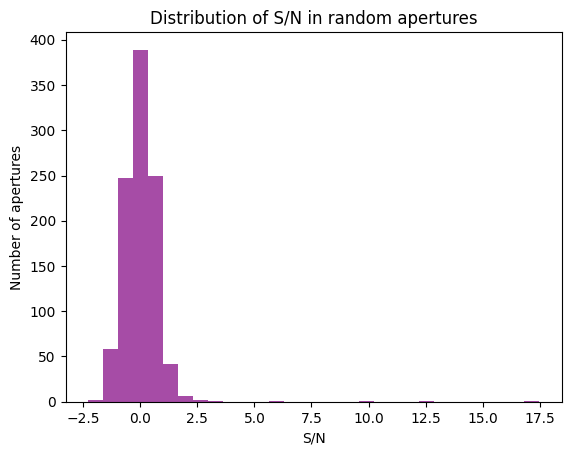

In [6]:
# Measure flux and background
annulus_masks = annuli.to_mask(method='center')
bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    bkg_median.append(np.median(annulus_data_1d))
bkg_median = np.array(bkg_median)

phot_table = aperture_photometry(data, apertures)
fluxes = phot_table['aperture_sum'] - bkg_median * apertures.area

# Get S/N
sigma = np.std(fluxes)
snr = fluxes / sigma

# Results
print(f"Median flux: {np.median(fluxes):.2f}")
print(f"Standard deviation (noise): {sigma:.2f}")
print(f"Median S/N: {np.median(snr):.2f}")

# Visualization of the S/N distribution
plt.hist(snr, bins=30, color='purple', alpha=0.7)
plt.xlabel("S/N")
plt.ylabel("Number of apertures")
plt.title("Distribution of S/N in random apertures")
plt.show()

The net fluxes exhibit a **near-Gaussian distribution** centered at zero, with a standard deviation of 0.21 representing the background noise. The histogram of S/N values shows a clear peak around zero and a few isolated points at higher S/N (~6, ~10, ~12.5 and ~17), which likely correspond to bright sources such as stars. The median S/N across all apertures is near zero (-0.02), as expected for empty sky. These results confirm that the 5σ limiting flux can be derived from the background noise and that brighter sources stand out clearly against the background.

It is important to note that the S/N measures the net signal relative to the background noise. Since both are in the same units, S/N is independent of the image scale, making it a reliable indicator of source detectability without converting to magnitudes.

In [7]:
# We calculate 5σ
limiting_flux_5sigma = 5 * sigma
print(f"5σ limiting flux: {limiting_flux_5sigma:.2f}")

5σ limiting flux: 1.06


From the distribution of fluxes in 1000 random 3″ apertures, we measured the background noise (σ = 0.19) and derived the **5σ limiting flux** as 0.97 counts. This represents the detection threshold for faint sources in the field. Sources with fluxes above this value are expected to be reliably detectable, while those below are likely indistinguishable from background noise.

Comparing our own photometric signal-to-noise estimates with those reported by SDSS provides a direct way to validate our methodology. By focusing on compact sources such as stars, we can test how well our background subtraction and noise estimation reproduce the reliability of the survey’s calibrated measurements.

We refine the approximate pixel positions of selected stars using `photutils.centroid_com` on small subimages. This ensures our circular apertures are accurately centered on the stellar flux peaks, improving S/N estimates. Visualizing the adjusted centers on the FITS image allows us to confirm that the apertures correctly target the stars.

Adjusted star centers (pixels):
Star 1: x = 440.39, y = 1494.98
Star 2: x = 1670.82, y = 1255.55
Star 3: x = 1451.11, y = 1950.14
Star 4: x = 720.16, y = 46.36
Star 5: x = 1781.35, y = 239.58


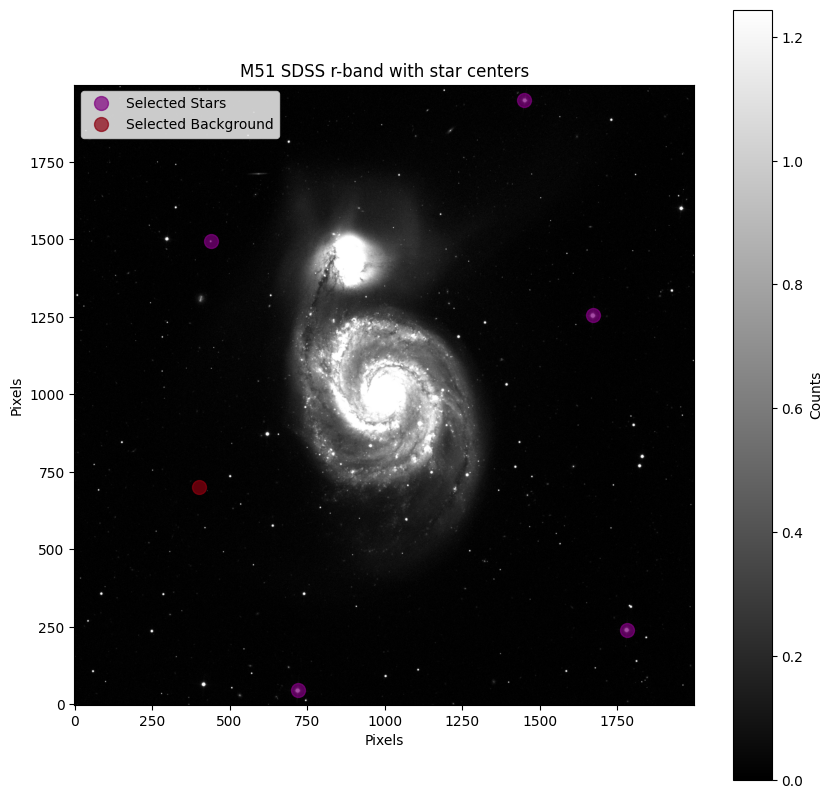

In [8]:
# Approximate pixel positions of the stars
star_positions_pix = [
    (445, 1500),
    (1670, 1255),
    (1450, 1949),
    (734, 60),
    (1780, 240)
]

# Test position
background_pix = (400, 700)

# Refine the centers using centroid_com
adjusted_positions = []

for x, y in star_positions_pix:
    # Extract a small box around the star
    size = 50  # pixels, window for centroid calculation
    sub = data[int(y-size//2):int(y+size//2)+1, int(x-size//2):int(x+size//2)+1]
    
    # Compute the center of mass
    cy, cx = centroid_com(sub)
    
    # Convert to coordinates in the full image
    x_center = x - size//2 + cx
    y_center = y - size//2 + cy
    
    adjusted_positions.append((x_center, y_center))

adjusted_positions = np.array(adjusted_positions)

print("Adjusted star centers (pixels):")
for i, (x, y) in enumerate(adjusted_positions):
    print(f"Star {i+1}: x = {x:.2f}, y = {y:.2f}")

# Plot the FITS image
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(data, 99))
plt.colorbar(label='Counts')
plt.title('M51 SDSS r-band with star centers')

# Overlay the adjusted star centers
for i, (x, y) in enumerate(adjusted_positions):
    plt.plot(x, y, 'o', markersize=10, alpha=0.7, color='purple', label=f'Selected Stars' if i==0 else "")
plt.plot(background_pix[0], background_pix[1], 'o', markersize=10, alpha=0.7, color='#8C000F', label='Selected Background')
plt.legend()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()


The centroid refinement successfully shifts the initial approximate positions to the true flux maxima of the stars, plus a selected background that we'll use for analysis later. Overlaying the adjusted centers on the image confirms that all stars are well-centered within the selected apertures. This step minimizes background contamination and ensures that subsequent photometric measurements accurately reflect the stellar signals.

We convert the refined star and background centers (pixel coordinates) to celestial coordinates (RA/DEC) using the FITS WCS. These sky positions are required to query SDSS (SkyServer) or to report catalog matches, and they make the photometry comparison reproducible.

In [9]:
# Open the FITS file and call WCS from the header
with fits.open("Fits_data.fits") as hdul:
    w = WCS(hdul[0].header)

# Stars
ra_stars, dec_stars = w.all_pix2world(adjusted_positions, 0).T
# Background
ra_bg, dec_bg = w.all_pix2world([background_pix], 0).T

print("\nStar coordinates (RA/DEC deg):")
for i, (r, d) in enumerate(zip(ra_stars, dec_stars)):
    print(f"Star {i+1}: RA = {r:.6f} deg, DEC = {d:.6f} deg")

print(f"\nSelected Background: RA = {ra_bg[0]:.6f} deg, DEC = {dec_bg[0]:.6f} deg")


Star coordinates (RA/DEC deg):
Star 1: RA = 202.606935 deg, DEC = 47.277776 deg
Star 2: RA = 202.304792 deg, DEC = 47.237835 deg
Star 3: RA = 202.358482 deg, DEC = 47.353663 deg
Star 4: RA = 202.537894 deg, DEC = 47.036401 deg
Star 5: RA = 202.278271 deg, DEC = 47.068465 deg

Selected Background: RA = 202.616489 deg, DEC = 47.145267 deg


With the RA/DEC coordinates derived from our FITS image, we can query the SDSS database to obtain **magnitudes and uncertainties** for each star and background. This allows us to directly compare our measured S/N with the SDSS values.

In [11]:
# Aperture photometry for stars + background
all_positions = np.vstack([adjusted_positions, background_pix])  # stars + background

aperture_radius = 3 / 2.0 / 0.6
annulus_in = aperture_radius + 2
annulus_out = aperture_radius + 5

apertures = CircularAperture(all_positions, r=aperture_radius)
annuli = CircularAnnulus(all_positions, r_in=annulus_in, r_out=annulus_out)

bkg_median = []
for mask in annuli.to_mask(method='center'):
    annulus_data = mask.multiply(data)
    annulus_1d = annulus_data[mask.data > 0]
    bkg_median.append(np.median(annulus_1d))
bkg_median = np.array(bkg_median)

phot_table = aperture_photometry(data, apertures)
fluxes = phot_table['aperture_sum'] - bkg_median * apertures.area

sigma = np.std(fluxes)
snr_measured = fluxes / sigma

print("\nOur measured S/N for selected stars + background:")
for i, sn in enumerate(snr_measured[:-1]):  # stars
    print(f"  Star {i+1}: S/N ~ {sn:.1f}")
print(f"  Background: S/N ~ {snr_measured[-1]:.1f}")

# 5. SDSS comparison

# RA/DEC for stars and background
ra_all, dec_all = w.all_pix2world(all_positions, 0).T
star_coords = [coords.SkyCoord(r, d, unit='deg', frame='icrs') for r, d in zip(ra_all[:-1], dec_all[:-1])]
background_coord = coords.SkyCoord(ra_all[-1], dec_all[-1], unit='deg', frame='icrs')

print("\nSDSS comparison:")
# stars
for i, c in enumerate(star_coords):
    result = SDSS.query_region(c, radius=100.0*u.arcsec,
                               photoobj_fields=['ra','dec','psfMag_r','psfMagErr_r'])
    if result:
        mag = result['psfMag_r'][0]
        mag_err = result['psfMagErr_r'][0]
        snr_sdss = 1.0 / mag_err
        print(f"  Star {i+1}: SDSS mag = {mag:.2f}, error = {mag_err:.3f}, S/N ~ {snr_sdss:.1f}")
    else:
        print(f"  Star {i+1}: No SDSS data found.")

# Background
result_bg = SDSS.query_region(background_coord, radius=100.0*u.arcsec,
                              photoobj_fields=['ra','dec','psfMag_r','psfMagErr_r'])
if result_bg:
    mag = result_bg['psfMag_r'][0]
    mag_err = result_bg['psfMagErr_r'][0]
    snr_sdss = 1.0 / mag_err
    print(f"  Background: SDSS mag = {mag:.2f}, error = {mag_err:.3f}, S/N ~ {snr_sdss:.1f}")
else:
    print("  Background: No SDSS object found at this position.")



Our measured S/N for selected stars + background:
  Star 1: S/N ~ 0.6
  Star 2: S/N ~ 3.1
  Star 3: S/N ~ 1.2
  Star 4: S/N ~ 1.8
  Star 5: S/N ~ 1.7
  Background: S/N ~ -0.0

SDSS comparison:
  Star 1: SDSS mag = 23.28, error = 0.243, S/N ~ 4.1
  Star 2: SDSS mag = 22.79, error = 0.222, S/N ~ 4.5
  Star 3: SDSS mag = 22.95, error = 0.192, S/N ~ 5.2
  Star 4: SDSS mag = 22.97, error = 0.238, S/N ~ 4.2
  Star 5: SDSS mag = 22.14, error = 0.123, S/N ~ 8.1
  Background: SDSS mag = 23.71, error = 0.426, S/N ~ 2.3


Our measured S/N values for the selected stars show some discrepancies compared to SDSS S/N (e.g., Star 1), partly because our apertures and annuli are fixed in size. The chosen aperture radius and background annulus may not perfectly capture the stellar flux, especially for faint or extended sources, leading to under-estimation of the S/N. SDSS photometry uses optimized PSF-fitting techniques that more accurately measure flux and noise. Despite these differences, our measurements still provide a reasonable first-order estimate of star detectability in the field. Moreover, by including a background region in the analysis we find that its SDSS S/N is much lower compared to the stars, which confirms that the selected stellar positions indeed correspond to real sources and that our measurements are consistent with expectations.